## 1. Data Loading with kagglehub




In [1]:
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Download the dataset dynamically from Kaggle
path = kagglehub.dataset_download("arjunbhasin2013/ccdata")
print("Path to dataset files:", path)

# Define the path to the file
file_path = f"{path}/CC GENERAL.csv"

# Load the dataset
data = pd.read_csv(file_path)
print(data.head())


100%|██████████| 340k/340k [00:00<00:00, 61.0MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/arjunbhasin2013/ccdata/versions/1
  CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUEN

## 2. Exploratory Data Analysis (EDA)

In [3]:
# Basic information about the dataset
print(data.info())
print(data.describe())

# Fill missing values for numeric columns only
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].median())

# Verify missing values after filling
print("Missing Values After Filling:\n", data.isnull().sum())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

## 3. A/B Testing Setup
Simulate an A/B test by splitting the dataset into two groups:

Group A: Customers without cashback offers.
Group B: Customers with cashback offers.

In [4]:
import numpy as np

# Randomly assign groups
np.random.seed(42)
data['Group'] = np.random.choice(['A', 'B'], size=len(data))

# Simulate cashback impact
data['Cashback Offer'] = np.where(data['Group'] == 'B', 0.1 * data['PURCHASES'], 0)

# Compute new total spending
data['Total Spending'] = data['PURCHASES'] + data['Cashback Offer']


## 4. Visualizations

Group Comparison for Spending Behavior

<ipython-input-5-36e0bf57d621>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Total Spending', data=data, palette='Set2')


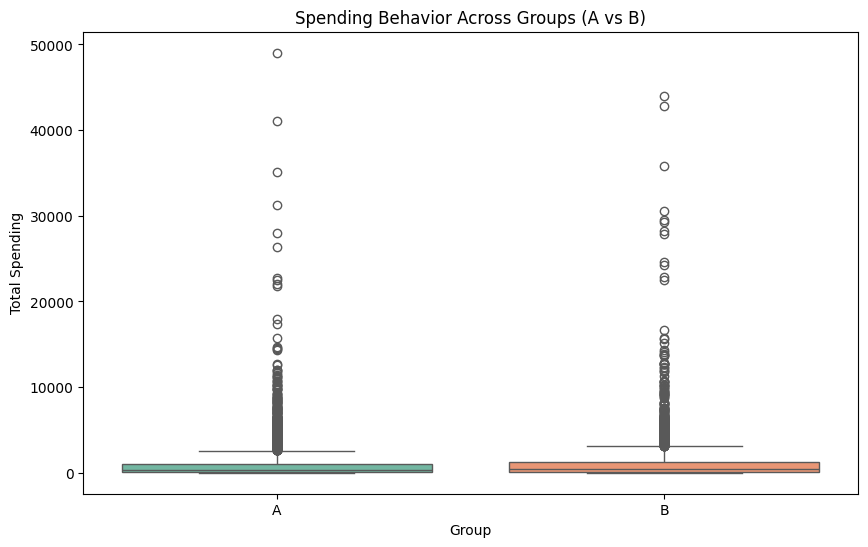

In [5]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Group', y='Total Spending', data=data, palette='Set2')
plt.title('Spending Behavior Across Groups (A vs B)')
plt.ylabel('Total Spending')
plt.xlabel('Group')
plt.show()


In [7]:
# Check the unique values in the 'Group' column
print(data['Group'].unique())

# Ensure 'Group' is a categorical column
data['Group'] = data['Group'].astype('category')


['A' 'B']


Distribution of Spending

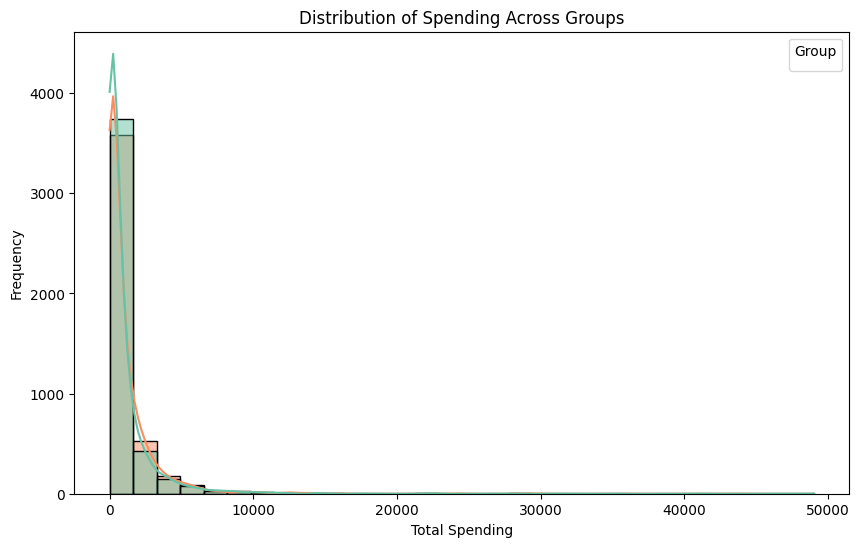

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='Total Spending', bins=30, kde=True, hue='Group', palette='Set2')
plt.title('Distribution of Spending Across Groups')
plt.xlabel('Total Spending')
plt.ylabel('Frequency')
plt.legend(title='Group')
plt.show()


##5. Statistical Analysis

**Hypothesis Testing**

Null Hypothesis (H0): No difference in spending between groups A and B.

Alternative Hypothesis (H1): There is a significant difference in spending.

In [9]:
from scipy.stats import ttest_ind

# Perform a t-test
group_a = data[data['Group'] == 'A']['Total Spending']
group_b = data[data['Group'] == 'B']['Total Spending']

t_stat, p_value = ttest_ind(group_a, group_b)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

if p_value < 0.05:
    print("Reject the null hypothesis: Significant difference in spending.")
else:
    print("Fail to reject the null hypothesis: No significant difference in spending.")


T-statistic: -2.263691454284087, P-value: 0.023616941603192207
Reject the null hypothesis: Significant difference in spending.


## Further Analysis:

Segment the groups by additional variables, such as customer demographics or tenure.
Perform a post-hoc analysis to identify subgroups driving the difference in spending.

<ipython-input-10-541268d7018e>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  spending_by_tenure = data.groupby(['Group', 'TENURE_GROUP'])['Total Spending'].mean().reset_index()


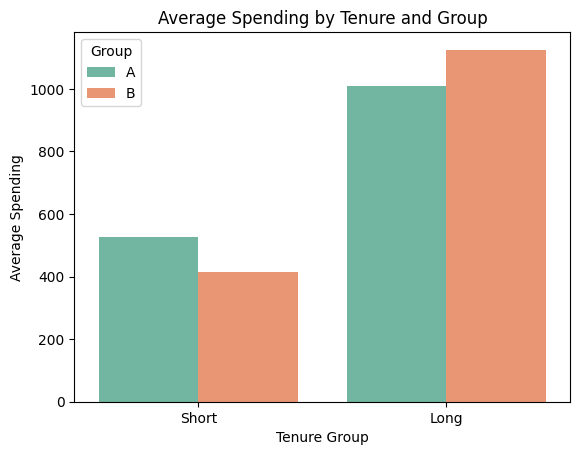

In [10]:
# Segment the data by 'TENURE' (e.g., short vs. long tenure)
data['TENURE_GROUP'] = pd.cut(data['TENURE'], bins=[0, 6, 12], labels=['Short', 'Long'])

# Calculate average spending for each segment
spending_by_tenure = data.groupby(['Group', 'TENURE_GROUP'])['Total Spending'].mean().reset_index()

# Visualize
sns.barplot(data=spending_by_tenure, x='TENURE_GROUP', y='Total Spending', hue='Group', palette='Set2')
plt.title('Average Spending by Tenure and Group')
plt.xlabel('Tenure Group')
plt.ylabel('Average Spending')
plt.show()


['A', 'B']
Categories (2, object): ['A', 'B']
['Long', 'Short']
Categories (2, object): ['Short' < 'Long']
['A_Long' 'B_Long' 'B_Short' 'A_Short']
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
 group1  group2  meandiff p-adj    lower      upper   reject
------------------------------------------------------------
 A_Long A_Short  -484.027 0.1695 -1090.3513  122.2973  False
 A_Long  B_Long  115.1797 0.0763    -7.9122  238.2716  False
 A_Long B_Short -595.4569 0.0281 -1146.2086  -44.7051   True
A_Short  B_Long  599.2067 0.0542    -7.1776  1205.591  False
A_Short B_Short -111.4298 0.9849  -921.2927   698.433  False
 B_Long B_Short -710.6366 0.0051 -1261.4543 -159.8188   True
------------------------------------------------------------


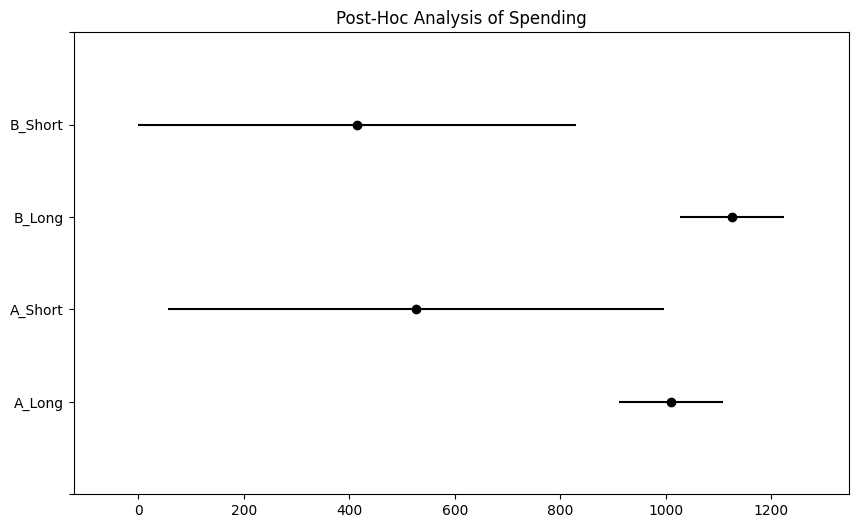

In [13]:
# Check unique values in 'Group' and 'TENURE_GROUP' columns
print(data['Group'].unique())
print(data['TENURE_GROUP'].unique())

# Combine 'Group' and 'TENURE_GROUP' into a new column 'Group_Tenure'
data['Group_Tenure'] = data['Group'].astype(str) + '_' + data['TENURE_GROUP'].astype(str)

# Verify the new column
print(data['Group_Tenure'].unique())

# Perform Tukey's HSD test
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform Tukey's HSD
tukey = pairwise_tukeyhsd(data['Total Spending'], data['Group_Tenure'], alpha=0.05)
print(tukey)

# Visualize Tukey's HSD results
tukey.plot_simultaneous()
plt.title('Post-Hoc Analysis of Spending')
plt.show()


<ipython-input-14-40f7f3fbfe36>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  spending_by_frequency = data.groupby(['Group', 'FREQUENCY_GROUP'])['Total Spending'].mean().reset_index()


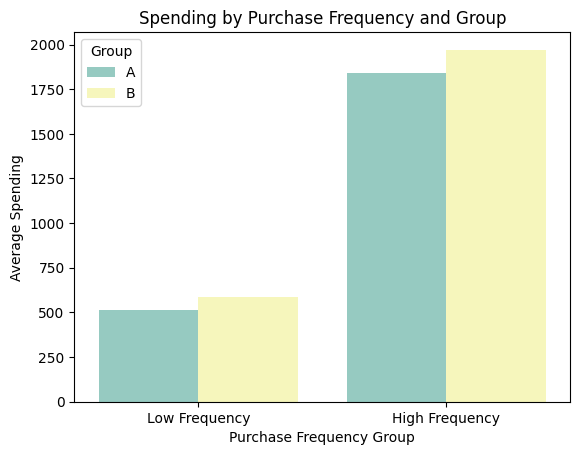

In [14]:
# Segment by purchase frequency
data['FREQUENCY_GROUP'] = pd.cut(data['PURCHASES_FREQUENCY'], bins=[0, 0.5, 1], labels=['Low Frequency', 'High Frequency'])

# Analyze spending by frequency and group
spending_by_frequency = data.groupby(['Group', 'FREQUENCY_GROUP'])['Total Spending'].mean().reset_index()

# Visualize
sns.barplot(data=spending_by_frequency, x='FREQUENCY_GROUP', y='Total Spending', hue='Group', palette='Set3')
plt.title('Spending by Purchase Frequency and Group')
plt.xlabel('Purchase Frequency Group')
plt.ylabel('Average Spending')
plt.show()
